In [2]:
import pickle
import xarray as xr
import pandas as pd
import warnings
import numpy as np
import rasterio
import hydromt
import os

In [3]:
waterlevels_fn = R"p:\11211461-010--eo-flood-ops\HoiAn\FEWS\Water_Level.csv"
trained_model_fn = R"p:\11211461-010--eo-flood-ops\HoiAn\FEWS\thresholding_model_ID6_new.pkl"
output_dir = R"p:\11211461-010--eo-flood-ops\HoiAn\FEWS\outputs"


In [4]:
import pandas as pd

# Read timezone info from the first line
with open(waterlevels_fn, "r") as f:
    tz_line = f.readline().strip()  # e.g. "GMT+7,ID6"

# Split by comma and extract the first part ("GMT+7")
tz_part = tz_line.split(",")[0].strip()  # "GMT+7"

# Parse numeric offset (e.g. +7)
offset_hours = int(tz_part.replace("GMT", ""))
print(f"Detected timezone offset: {offset_hours:+d} hours")

# Read actual data (skip the first line only) 
df_water = pd.read_csv(waterlevels_fn, skiprows=[0])
df_water.rename(columns={df_water.columns[0]: "datetime", df_water.columns[1]: "water_level"}, inplace=True)

# Parse datetimes and convert to UTC 
df_water["datetime"] = pd.to_datetime(df_water["datetime"], format="%Y-%m-%d %H:%M:%S")

# Assign timezone (GMT+7) then convert to UTC (GMT+0)
# NOTE: for "GMT+7", you must localize with "Etc/GMT-7" because of reversed sign convention
df_water["datetime"] = (
    df_water["datetime"]
    .dt.tz_localize(f"Etc/GMT{-offset_hours}")
    .dt.tz_convert("UTC")
)


Detected timezone offset: +7 hours


In [6]:
tz_line.split(",")[-1].strip() 

'ID6'

In [41]:
gauge_levels = df_water["water_level"].to_numpy()
timestamps = df_water["datetime"]

In [40]:
# Load water level data
# df_water = pd.read_csv(waterlevels_fn, skiprows=[1])
# df_water.rename(columns={df_water.columns[0]: "datetime"}, inplace=True)
# df_water["datetime"] = pd.to_datetime(df_water["datetime"])

# Select the gauge column of interest
# gauge_col = "ID6"

# # Check for missing or invalid values (-999)
# invalid_rows = df_water[df_water[gauge_col] == -999]

# if not invalid_rows.empty:
#     warnings.warn(
#         f"Removed {len(invalid_rows)} row(s) with missing value (-999) at timestamps: {invalid_rows['datetime'].to_list()}",
#         UserWarning
#     )
#     # Drop invalid rows
#     df_water = df_water[df_water[gauge_col] != -999]

# Extract gauge levels and timestamps
# gauge_levels = df_water[gauge_col].to_numpy()
# timestamps = df_water["datetime"]

In [42]:
def generate_ds(water_levels, timestamps, tm, transform, crs=rasterio.crs.CRS.from_epsg(4326)):
    """
    Generate a CF-compliant xarray Dataset of wet/dry masks (boolean) or
    water depths (float) for a time series of water levels using a trained model.
    Includes water_level as a coordinate.

    Args:
        water_levels (list or array): Water levels to infer wet/dry masks or depths.
        timestamps (list or pd.DatetimeIndex): Corresponding timestamps.
        tm: Trained model with method tm.infer(level).
            - Returns boolean arrays for thresholding models.
            - Returns masked float arrays for manifold models.
        transform (Affine): Rasterio affine transform of the raster.
        crs (rasterio.crs.CRS): CRS of the raster (must be EPSG:4326).

    Returns:
        xr.Dataset: CF-compliant Dataset with dimensions (time, lat, lon)
    """
    def array_to_da(array, is_bool):
        """Convert boolean/float/masked array to xarray.DataArray with lat/lon."""
        if not isinstance(array, np.ma.MaskedArray):
            masked = np.ma.masked_array(array)
        else:
            masked = array

        nrows, ncols = masked.shape
        xs = np.arange(ncols)
        ys = np.arange(nrows)
        lon, _ = rasterio.transform.xy(transform, 0, xs, offset="center")
        _, lat = rasterio.transform.xy(transform, ys, 0, offset="center")
        lon = np.array(lon)
        lat = np.array(lat)

        # Ensure latitude is sorted ascending
        if lat[0] > lat[-1]:
            lat = lat[::-1]
            masked = masked[::-1, :]

        # Convert data
        if is_bool:
            data = masked.astype(np.float32)  # True/False → 1.0/0.0
        else:
            data = masked.filled(np.nan).astype(np.float32)

        da = xr.DataArray(
            data,
            dims=("lat", "lon"),
            coords={"lat": lat, "lon": lon},
        )

        if is_bool:
            da.attrs.update({"long_name": "wet_dry_mask", "units": "1"})
        else:
            da.attrs.update({"long_name": "water_depth", "units": "m"})

        da.attrs["grid_mapping"] = "spatial_ref"
        return da

    # Detect model type (boolean vs float)
    test_out = tm.infer(water_levels[0])
    is_bool = np.issubdtype(test_out.dtype, np.bool_)

    arrays = []
    for lvl in water_levels:
        arr = tm.infer(lvl)
        da = array_to_da(arr, is_bool)
        arrays.append(da)

    # Stack along time
    varname = "wet_dry" if is_bool else "water_depth"
    ts_da = xr.concat(arrays, dim=pd.Index(timestamps, name="time"))

    # Build Dataset
    ds = xr.Dataset({varname: ts_da})

    # Add water_level as coordinate along time
    ds = ds.assign_coords({"water_level": ("time", water_levels)})
    ds["water_level"].attrs.update({"long_name": "water_level", "units": "m"})

    # Add CF-compliant spatial_ref
    ds["spatial_ref"] = xr.DataArray(
        0,
        attrs={
            "spatial_ref": crs.to_wkt(),
            "grid_mapping_name": "latitude_longitude",
            "longitude_of_prime_meridian": 0.0,
            "semi_major_axis": 6378137.0,
            "inverse_flattening": 298.257223563,
        },
    )
    ds[varname].attrs["grid_mapping"] = "spatial_ref"

    # Coordinate metadata
    ds["lat"].attrs.update({"standard_name": "latitude", "units": "degrees_north"})
    ds["lon"].attrs.update({"standard_name": "longitude", "units": "degrees_east"})
    ds.raster.set_crs("EPSG:4326")

    return ds

In [43]:
# Load the trained model back
with open(trained_model_fn, "rb") as f:
    test_tm = pickle.load(f)

print("Model successfully loaded!")
print(type(test_tm))  # should show the type of the loaded model

Model successfully loaded!
<class 'eo_flood_ops.thresholding_model.ThresholdingModel'>


In [12]:
# Load the trained model back
with open(R"p:\11211461-010--eo-flood-ops\HoiAn\FEWS\manifold_model_ID6_new.pkl", "rb") as f:
    test_tm = pickle.load(f)

print("Model successfully loaded!")
print(type(test_tm))  # should show the type of the loaded model

Model successfully loaded!
<class 'eo_flood_ops.manifold_model.ManifoldModel'>


In [44]:
from affine import Affine


In [45]:
# Define affine transform
transform = Affine(
    0.00026949458523585647, 0.0, 108.04873355319717,
    0.0, -0.00026949458523585647, 16.08101139560879
)

In [46]:
ds = generate_ds(
    gauge_levels,
    timestamps,
    test_tm,
    transform,
)

In [52]:
# Convert time to naive datetime64 (UTC)
ds = ds.assign_coords(
    time=pd.DatetimeIndex(ds.time.values).tz_localize(None)
)


In [53]:
ds

<xarray.Dataset> Size: 153MB
Dimensions:      (lat: 1163, lon: 1317, time: 25)
Coordinates:
  * lat          (lat) float64 9kB 15.77 15.77 15.77 15.77 ... 16.08 16.08 16.08
  * lon          (lon) float64 11kB 108.0 108.0 108.0 ... 108.4 108.4 108.4
  * time         (time) datetime64[ns] 200B 2023-11-13T18:00:00 ... 2023-11-1...
    water_level  (time) float64 200B 1.12 1.03 0.93 0.85 ... 3.13 3.2 3.26 3.29
Data variables:
    wet_dry      (time, lat, lon) float32 153MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    spatial_ref  int64 8B 0

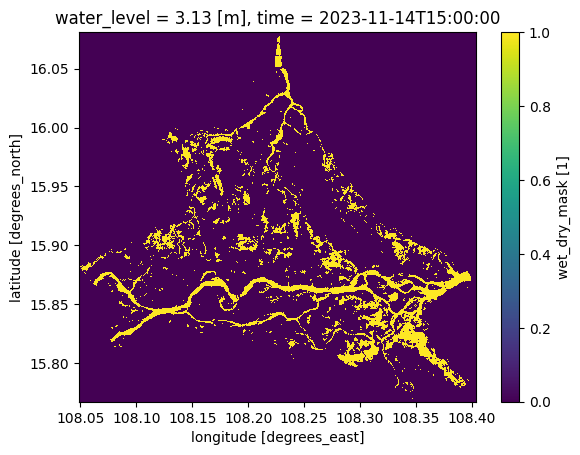

In [55]:
ds.sel(time="2023-11-14T15:00:00")["wet_dry"].plot()

In [56]:
output_path = os.path.join(output_dir, "fews_output.nc")
ds.to_netcdf(output_path)

In [57]:
rr = xr.open_dataset(output_path)

In [58]:
rr

<xarray.Dataset> Size: 153MB
Dimensions:      (time: 25, lat: 1163, lon: 1317)
Coordinates:
  * time         (time) datetime64[ns] 200B 2023-11-13T18:00:00 ... 2023-11-1...
  * lat          (lat) float64 9kB 15.77 15.77 15.77 15.77 ... 16.08 16.08 16.08
  * lon          (lon) float64 11kB 108.0 108.0 108.0 ... 108.4 108.4 108.4
    water_level  (time) float64 200B ...
Data variables:
    wet_dry      (time, lat, lon) float32 153MB ...
    spatial_ref  int64 8B ...